# Mixture of Gaussian Networks

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

import numpy as np

from keras.activations import sigmoid, softmax
from keras.layers import Dense, Input, merge, Lambda
from keras.layers.core import Activation
from keras.models import Sequential, Model
from keras import backend as K

## Create some transposed one-to-many noisy sine data

<IPython.core.display.Javascript object>


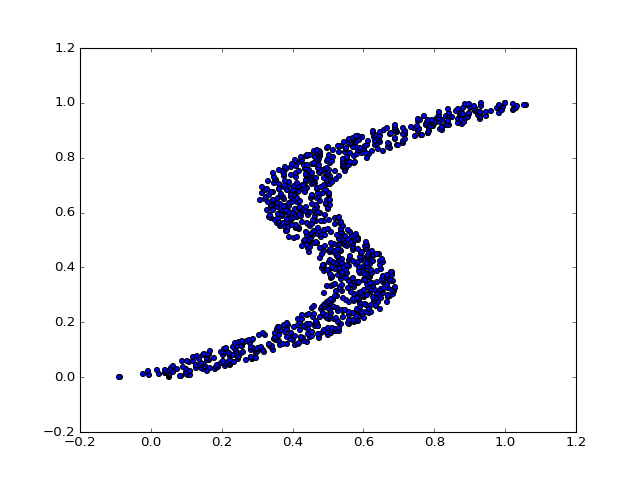

In [3]:
def data():
    n = 1000
    y = np.linspace(0, 1, n)
    X = y + 0.3 * np.sin(2 * np.pi * y) + np.random.uniform(-0.1, 0.1, size=(n,))

    return X, y

X, y = data()
plt.scatter(X, y)

## Create a linear output model to use as baseline

In [4]:
x_linear = Input(shape=(1,))
h1_linear = Dense(113, activation='relu', name='hidden1')(x_linear)
h2_linear = Dense(114, activation='relu', name='hidden2')(h1_linear)
output_linear = Dense(1, name='y')(h2_linear)

model_linear = Model(x_linear, output_linear)
model_linear.compile(optimizer='rmsprop', loss='mean_squared_error')
model_linear.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
hidden1 (Dense)                  (None, 113)           226         input_1[0][0]                    
____________________________________________________________________________________________________
hidden2 (Dense)                  (None, 114)           12996       hidden1[0][0]                    
____________________________________________________________________________________________________
y (Dense)                        (None, 1)             115         hidden2[0][0]                    
Total params: 13337
_______________________________________________________________________

In [5]:
nb_epoch = 100
batch_size = 32
model_linear.fit(
    X.reshape(-1, 1),
    y,
    shuffle=True,
    nb_epoch=nb_epoch,
    batch_size=batch_size
)

Epoch 1/100
1000/1000 [==============================] - 0s - loss: 0.0939     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 0.0493     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: 0.0487     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: 0.0485     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: 0.0485     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: 0.0484     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: 0.0481     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: 0.0481     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: 0.0480     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: 0.0479     
Epoch 11/100
1000/1000 [==============================] - 0s - loss: 0.0469     
Epoch 12/100
1000/1000 [==============================] - 0s - loss: 0.0475     
Epoch 13/100
1000/1000 [=============

## Predict and plot

<IPython.core.display.Javascript object>


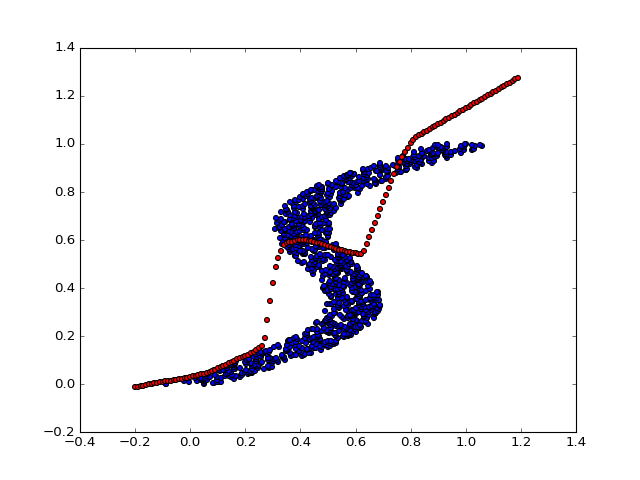

In [6]:
X_test = np.arange(-0.2, 1.2, 0.01)
y_pred = model_linear.predict(X_test)
plt.figure()
plt.scatter(X, y)
plt.scatter(X_test, y_pred, c='r')

#### Ouch, looks like the model outputs the mean in most of places. It also totally fails at the right edge.

## Create a Mixture Gaussian Network to mitigate the problems

In [7]:
n_components = 10

x = Input(shape=(1,))
h1 = Dense(100, activation='relu', name='hidden1')(x)
h2 = Dense(100, activation='relu', name='hidden2')(h1)
z_mean = Dense(n_components, name='z_means')(h2)
z_std = Dense(n_components, activation=K.exp, name='z_std')(h2)
z_alpha = Dense(n_components, activation='softmax', name='z_alpha')(h2)

output = merge([z_mean, z_std, z_alpha], mode='concat', concat_axis=-1)
model = Model(x, output)

## Define the network cost

In [8]:
def cost(y_true, output):
    z_mean_ = output[:, :n_components]
    z_std_ = output[:, n_components:2*n_components]
    z_alpha_ = output[:, 2*n_components:3*n_components]
    
    y_true_ = K.T.repeat(y_true, n_components, -1)
    
    c = -K.log(
        K.sum(
            z_alpha_ / (z_std_ * K.sqrt(2 * np.pi)) * K.exp(
                -K.square(y_true_ - z_mean_) / (2 * K.square(z_std_))
            ),
            axis=-1
        )
    )
    return c

## Compile and run

In [9]:
model.compile(optimizer='rmsprop', loss=cost)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
hidden1 (Dense)                  (None, 100)           200         input_2[0][0]                    
____________________________________________________________________________________________________
hidden2 (Dense)                  (None, 100)           10100       hidden1[0][0]                    
____________________________________________________________________________________________________
z_alpha (Dense)                  (None, 10)            1010        hidden2[0][0]                    
___________________________________________________________________________________________

In [13]:
model.fit(
    X.reshape(-1, 1),
    y,
    shuffle=True,
    nb_epoch=nb_epoch,
    batch_size=batch_size
)

Epoch 1/100
1000/1000 [==============================] - 0s - loss: -0.8950     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: -0.9226     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: -0.9302     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: -0.9014     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: -0.9151     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: -0.9474     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: -0.9249     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: -0.9291     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: -0.9182     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: -0.9021     
Epoch 11/100
1000/1000 [==============================] - 0s - loss: -0.9450     
Epoch 12/100
1000/1000 [==============================] - 0s - loss: -0.9273     
Epoch 13/100
1000/1000 [=

## Predict to sanity check

In [14]:
pred_params = model.predict(X_test)

mus = pred_params[:, :n_components]
sigmas = pred_params[:, n_components:2*n_components]
alphas = pred_params[:, 2*n_components:3*n_components]

y_pred = map(
    lambda mu, sigma, alpha: mu[np.argmax(alpha/sigma)],
    mus, sigmas, alphas
)

<IPython.core.display.Javascript object>


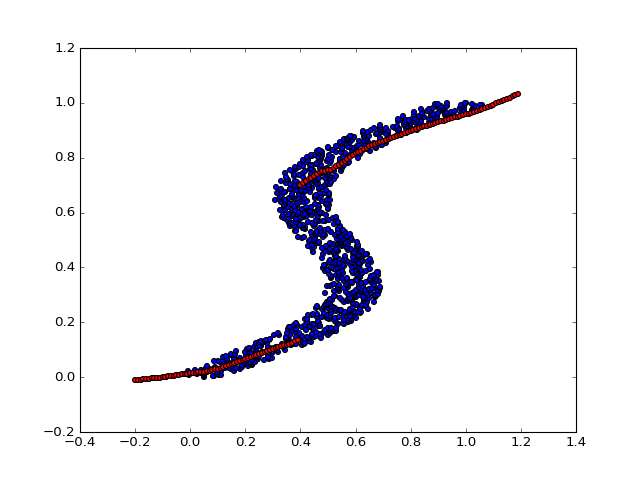

In [15]:
plt.figure()
plt.scatter(X, y)
plt.scatter(X_test, y_pred, c='r')